## Topics Covered

* Text Vectorization for CNNs
* Word Embeddings indexing
* Text Classification with Neural Networks (CNNs)
* Residual Connections



## Import Libraries

In [ ]:
!pip install --upgrade gensim
# Restart Session
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from copy import deepcopy

## Assert whether ``PyTorch`` can use an available GPU card

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
!nvidia-smi

Wed Jun  4 14:51:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

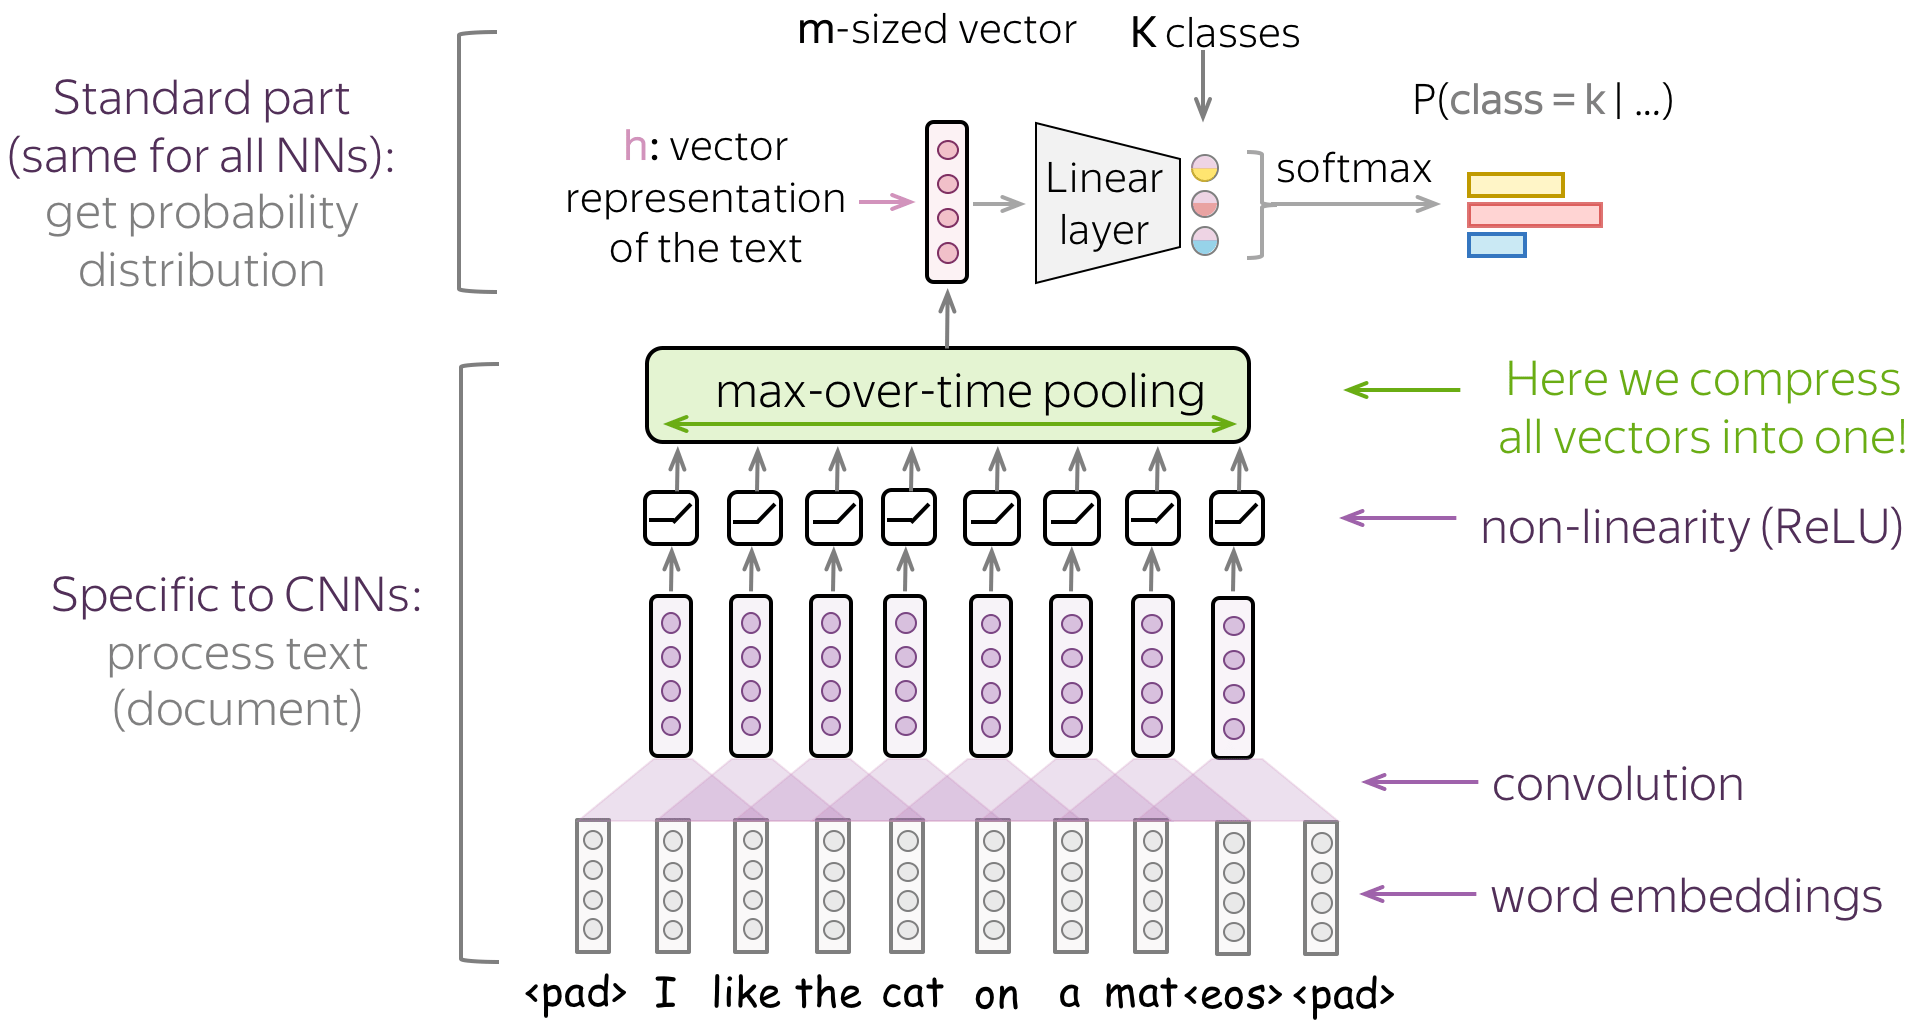

## Data Preprocessing

We will use the ``20newsgroups`` dataset. This is a single-label multi-class dataset with $20$ categories. We load and split the data into training and validation sets.

We will use integer encoding to represent each text and then match each integer (token) with a pre-trained ``Word2Vec`` embedding, initializing the embedding matrix $E$. We will keep the top 10000 tokens, based on frequency on the corpus.

We will also use the average length of the training split for padding the sequences to a predefined length.




In [4]:
# Load 20 Newsgroups dataset
# categories = ['comp.graphics', 'sci.space']
newsgroups_data = fetch_20newsgroups(subset='all',
                                     remove=('headers', 'footers', 'quotes'))
texts, labels = newsgroups_data.data, newsgroups_data.target

X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.3, random_state=42)

print(f'Number of training examples: {len(X_train)}')
print(f'Categories: {np.unique(y_train)}')

avg_length = int(np.mean([len(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split()) for text in X_train]))

print(f'Training corpus average text length: {avg_length}')

# Create custom vocabulary using CountVectorizer
vectorizer = CountVectorizer(max_features=30000)
vectorizer.fit(X_train)
custom_vocab = vectorizer.vocabulary_

# Load Word2Vec embeddings using gensim downloader
word2vec = api.load('word2vec-google-news-300')

# Map custom vocabulary to Word2Vec indices with 'PAD' and 'UNK' tokens
embedding_dim = 300
average_embedding = np.mean(word2vec.vectors, axis=0)  # average of all embeddings
vocab = {'__PAD__': 0, '__UNK__': 1}
vocab.update({word: idx + 2 for idx, word in enumerate(custom_vocab)})
embedding_matrix = np.zeros((len(vocab), embedding_dim))
embedding_matrix[0] = np.zeros(embedding_dim)  # PAD token embedding
embedding_matrix[1] = average_embedding  # UNK token embedding
for word, idx in vocab.items():
    if word in word2vec:
        embedding_matrix[idx] = word2vec[word]
    elif idx > 1:
        embedding_matrix[idx] = average_embedding

del word2vec

Number of training examples: 13192
Categories: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Training corpus average text length: 187
[==================================================] 100.0% 1662.8/1662.8MB downloaded


## Creating a Dataset

We will use the ``Dataset`` class from ``PyTorch`` to handle the text data. We will pad the text sequences with $0$ to a pre-defined length (the average number of tokens in the training split).

In [5]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = [self.tokenize(text, vocab, max_length) for text in texts]
        self.labels = labels

    def tokenize(self, text, vocab, max_length):
        text = text.lower().split()
        tokens = [vocab.get(word, vocab['__UNK__']) for word in text]
        if len(tokens) < max_length:
            tokens += [vocab['__PAD__']] * (max_length - len(tokens))
        else:
            tokens = tokens[:max_length]
        return tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

train_dataset = TextDataset(X_train, y_train, vocab, avg_length)
val_dataset = TextDataset(X_val, y_val, vocab, avg_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [6]:
train_dataset[23]

(tensor([   5, 1737,   14,    1, 1739,   57,  165,    1,   51,    1,    1,    1,
            5, 1741,   26,    1,    1, 1743,    1,  149,    1,  385,  801,  387,
          167,   85, 1741,   26,  278,  841, 1739, 1744,   19,  257,    1,    1,
            5,    1,    1,    1,    1,  512, 1466,  205,    1,    1,   82,    5,
          855, 1747,  498,    1,  376,   26,  119,    1,   74,    1,    1,  104,
          855,  221, 1748,   14, 1749,    1,    5, 1739,  241,  856, 1478, 1439,
            1,   60,    5, 1585, 1194,   26,    5, 1749,    1,    1,    1, 1751,
           85,   82,    1,   14,   85,    1,   51,    1, 1752,   19, 1753,   13,
            1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [7]:
X_train[23]

"    The IRQ and interface-select jumpers are pretty straightforward, but I\n    don't grok the settings of W10-W18 (also labelled A15 through A18).\n    Could somebody tell me which settings of these four jumpers correspond\n    to what I/O addresses?\n    \nThe U-B PCNIC (also OEMed by IBM for a while) is the only Ethernet card I\nknow of that doesn't use I/O addresses.  It only has interrupts and shared\nmemory.  The jumpers you see control bits 15-18 in the base address of the\nshared memory.  I can't recall which is 1 and which 0, but that's easy\nto determine with DEBUG."

## Define the model

We will create a model class and parameterize our neural network with several choices

CNNs are employed over word sequences in three modes:

- Valid (No padding): a representation per n-gram.
- Same (Padding): a representation per token (timestep).

In [8]:
# Define a CNN model with Global Max Pooling / Self-Attention
class CNNModel(nn.Module):
    def __init__(self, vocab_size,
                 embed_dim, output_dim, attention_dim=None,
                 num_filters=100, ngram_kernel_size=2,
                 pretrained_embeddings=True, freeze_embeddings=False,
                 num_layers=1,
                 use_pooling=False, use_attention=False, dropout_rate = 0.4):
        super(CNNModel, self).__init__()
        self.use_pooling = use_pooling
        self.use_attention = use_attention
        self.attention_mlp = None
        self.dropout = dropout_rate
        self.drop_en = nn.Dropout(self.dropout)
        assert self.use_pooling or self.use_attention
        if self.use_pooling:
          assert not self.use_attention, "Cannot use pooling and attention at the same time"
        elif self.use_attention:
          assert not self.use_pooling, "Cannot use pooling and attention at the same time"
        # Embeddings
        if pretrained_embeddings:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(torch.tensor(embedding_matrix,
                                                                                                             dtype=torch.float32),
                                                                                                freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # CNN layers (encoder)
        self.conv_layers = nn.ModuleList()
        for layer_idx in range(num_layers):
          if layer_idx == 0:
            in_channels = embed_dim
          else:
            in_channels = num_filters

          self.conv_layers.append(nn.Conv1d(in_channels=in_channels,
                                            out_channels=num_filters,
                                            kernel_size=ngram_kernel_size,
                                            padding='valid'))

        # Attention or max-pooling to get a fixed-sized representation
        if self.use_attention:
          # Feel free to customize the Attention MLP
          assert attention_dim is not None, "Attention dimension must be specified"
          self.attention_mlp = torch.nn.Sequential(
              torch.nn.Linear(num_filters, attention_dim),
              torch.nn.Tanh(),
              torch.nn.Linear(attention_dim, 1)
          )

        # Classification layer(s)
        self.fc = nn.Linear(num_filters, output_dim)  # you can add a MLP head



    def forward(self, x):
        z = self.embedding(x)
        z = self.drop_en(z)

        # Transpose x because Conv1d expects input of (batch_size, in_channels, sequence_length) where in_channels maps to our embedding_dim here
        z = z.transpose(1, 2)

        # Caution: Do not add dropout between conv layers. Dropout can be added only before or/and after conv layers
        # Conv layers activation should always be ReLU
        for layer_idx in range(len(self.conv_layers)):
          z = self.conv_layers[layer_idx](z)
          z = torch.nn.ReLU()(z)

        if self.use_pooling:
            # pooled = torch.max(z, dim=-1)[0]  # max along all states
            # equivalently:
            pooling = nn.AdaptiveMaxPool1d(output_size=1)
            pooled = pooling(z).squeeze()
            return self.fc(pooled)
        elif self.use_attention:
            attention_weights = self.attention_mlp(z.transpose(1, 2))  # (batch_size, sequence_length, 1)

            # give very large negative value to padding tokens to be zeroed-out by softmax ONLY IF conv1d padding is Same
            # padding_mask = (x == 0).unsqueeze(-1)  # (batch_size, sequence_length, 1)
            # attention_weights -= 100000.0 * padding_mask.float()
            attention_weights = torch.softmax(attention_weights, dim=1)
            attention_output = torch.sum(z.transpose(1, 2) * attention_weights, dim=1)  # dot product
            return self.fc(self.drop_en(attention_output))

In [9]:
class MultiFilterCNNModel(nn.Module):
  def __init__(self, vocab_size,
               embed_dim, output_dim, attention_dim=None,
               num_filters=100,
               pretrained_embeddings=True, freeze_embeddings=False,
               num_layers=1,
               use_pooling=False, use_attention=False, dropout_rate = 0.4):
    super(MultiFilterCNNModel, self).__init__()
    self.use_pooling = use_pooling
    self.use_attention = use_attention
    self.attention_mlp = None
    self.dropout = dropout_rate
    self.drop_en = nn.Dropout(self.dropout)
    self.relu = torch.nn.ReLU()
    assert self.use_pooling or self.use_attention
    if self.use_pooling:
      assert not self.use_attention, "Cannot use pooling and attention at the same time"
    elif self.use_attention:
      assert not self.use_pooling, "Cannot use pooling and attention at the same time"
    if pretrained_embeddings:
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(torch.tensor(embedding_matrix,
                                                                                                         dtype=torch.float32),
                                                                                            freeze=freeze_embeddings)
    else:
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

    self.embeddings_projection = nn.Linear(embed_dim, num_filters)  # if num_filters != embed_dim


    self.bigram_layers = nn.ModuleList()
    self.trigram_layers = nn.ModuleList()
    self.fourgram_layers = nn.ModuleList()
    for layer_idx in range(num_layers):
      in_channels = num_filters

      self.bigram_layers.append(nn.Conv1d(in_channels=in_channels,
                                          out_channels=num_filters,
                                          kernel_size=2,
                                          padding='same'))
      self.trigram_layers.append(nn.Conv1d(in_channels=in_channels,
                                           out_channels=num_filters,
                                           kernel_size=3,
                                           padding='same'))
      self.fourgram_layers.append(nn.Conv1d(in_channels=in_channels,
                                            out_channels=num_filters,
                                            kernel_size=4,
                                            padding='same'))


    self.global_max_pooling = nn.AdaptiveMaxPool1d(output_size=1)
    self.fc = nn.Linear(num_filters * 3, output_dim)  # you can add a MLP head

    if self.use_attention:
      # Feel free to customize the Attention MLP
      assert attention_dim is not None, "Attention dimension must be specified"
      self.attention_mlp = torch.nn.Sequential(
          nn.Linear(num_filters * 3, attention_dim),
          nn.Tanh(),
          nn.Linear(attention_dim, 1)
      )

  def forward(self, x):
    z = self.embedding(x)  # (batch_size, sequence_length, embed_dim)
    z = self.embeddings_projection(z)  # (batch_size, sequence_length, num_filters)
    z = self.drop_en(z)

    # Transpose x because Conv1d expects input of (batch_size, in_channels, sequence_length) where in_channels maps to our num_filters here
    z = z.transpose(1, 2)

    bigram, trigram, fourgram = z, z, z
    for bigram_layer, trigram_layer, fourgram_layer in zip(self.bigram_layers, self.trigram_layers, self.fourgram_layers):

      bigram = self.relu(bigram_layer(bigram)) + bigram

      trigram = self.relu(trigram_layer(trigram)) + trigram

      fourgram = self.relu(fourgram_layer(fourgram)) + fourgram

    if self.use_pooling:
      bigram = self.global_max_pooling(bigram).squeeze()
      trigram = self.global_max_pooling(trigram).squeeze()
      fourgram = self.global_max_pooling(fourgram).squeeze()
    if self.use_attention:

      bigram_attention_weights = self.attention_mlp(bigram.transpose(1, 2))  # (batch_size, sequence_length, 1)
      bigram_attention_weights = torch.softmax(bigram_attention_weights, dim=1)
      bigram = torch.sum(bigram.transpose(1, 2) * bigram_attention_weights, dim=1)  # dot product

      trigram_attention_weights = self.attention_mlp(trigram.transpose(1, 2))  # (batch_size, sequence_length, 1)
      trigram_attention_weights = torch.softmax(trigram_attention_weights, dim=1)
      trigram = torch.sum(trigram.transpose(1, 2) * trigram_attention_weights, dim=1)  # dot product

      fourgram_attention_weights = self.attention_mlp(fourgram.transpose(1, 2))  # (batch_size, sequence_length, 1)
      fourgram_attention_weights = torch.softmax(fourgram_attention_weights, dim=1)
      fourgram = torch.sum(fourgram.transpose(1, 2) * fourgram_attention_weights, dim=1)  # dot product


    output = torch.cat((bigram, trigram, fourgram), dim=1)
    output = self.drop_en(output)
    return self.fc(output)


## Training and Evaluation scripts

We will define two functions which will train and evaluate our model

In [10]:
import os

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer,
                epochs=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_path = None  # To keep track of the previous best model file

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts = texts.to(device)
            labels = labels.long().to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts = texts.to(device)
                labels = labels.long().to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        if epoch % 2 == 0:
            print(f'Epoch: {epoch:4.0f} / {epochs} | Training Loss: {train_loss / len(train_loader):.5f}, Validation Loss: {val_loss / len(val_loader):.5f}')

        # You can also add early stopping here...

        if (val_loss / len(val_loader)) < best_val_loss:
          best_val_loss = val_loss / len(val_loader)
          new_model_path = f'cnn_best_model_epoch_{epoch+1}.pth'

          # Delete the previous best model if it exists
          if best_model_path is not None:
              os.remove(best_model_path)

          # Save the new best model
          torch.save(model.state_dict(), new_model_path)
          best_model_path = new_model_path  # Update the best model path

          # load model later with model.load_state_dict(torch.load(path))

    return train_losses, val_losses, best_model_path

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            preds = torch.argmax(model(texts), dim=1)  # argmax of predictions
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

Training BigramCNN_GMP...
CNNModel(
  (drop_en): Dropout(p=0.4, inplace=False)
  (embedding): Embedding(30002, 300)
  (conv_layers): ModuleList(
    (0): Conv1d(300, 64, kernel_size=(2,), stride=(1,), padding=valid)
    (1-5): 5 x Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=valid)
  )
  (fc): Linear(in_features=64, out_features=20, bias=True)
)
Epoch:    0 / 10 | Training Loss: 2.67726, Validation Loss: 2.31047
Epoch:    2 / 10 | Training Loss: 1.86713, Validation Loss: 1.80016
Epoch:    4 / 10 | Training Loss: 1.28941, Validation Loss: 1.59672
Epoch:    6 / 10 | Training Loss: 0.96445, Validation Loss: 1.65290
Epoch:    8 / 10 | Training Loss: 0.73583, Validation Loss: 1.82543
Training TrigramCNN_GMP...
CNNModel(
  (drop_en): Dropout(p=0.4, inplace=False)
  (embedding): Embedding(30002, 300)
  (conv_layers): ModuleList(
    (0): Conv1d(300, 64, kernel_size=(3,), stride=(1,), padding=valid)
    (1-5): 5 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=valid)
  )
  (fc)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Epoch:    0 / 10 | Training Loss: 2.09265, Validation Loss: 1.48685
Epoch:    2 / 10 | Training Loss: 1.04775, Validation Loss: 1.20525
Epoch:    4 / 10 | Training Loss: 0.70628, Validation Loss: 1.23435
Epoch:    6 / 10 | Training Loss: 0.52122, Validation Loss: 1.34538
Epoch:    8 / 10 | Training Loss: 0.41917, Validation Loss: 1.54648


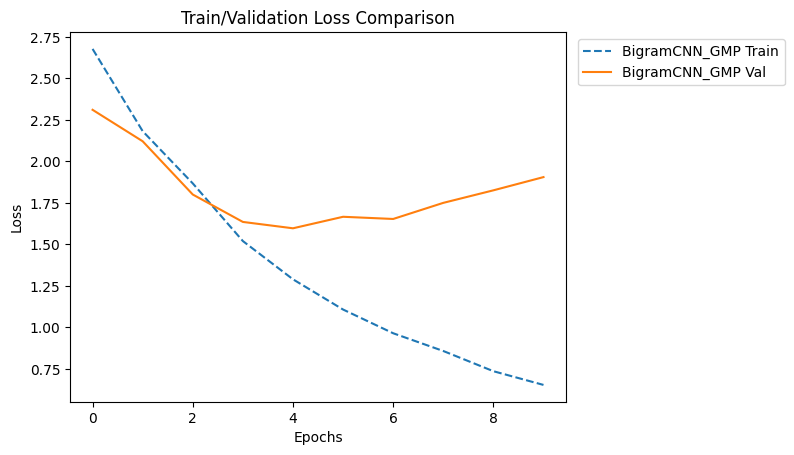

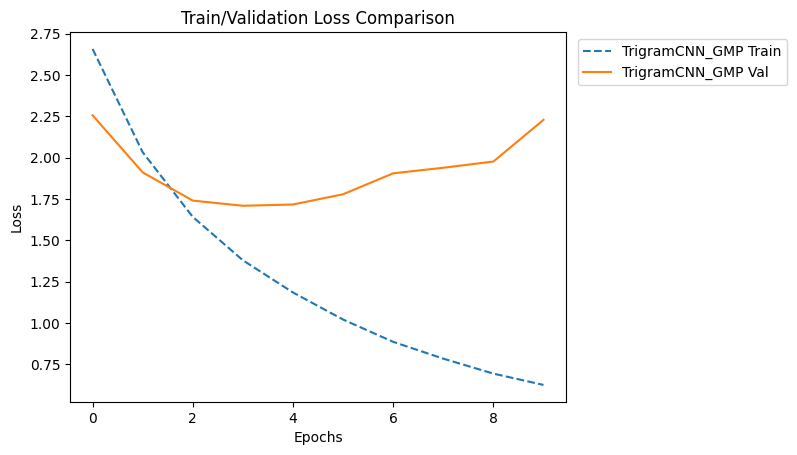

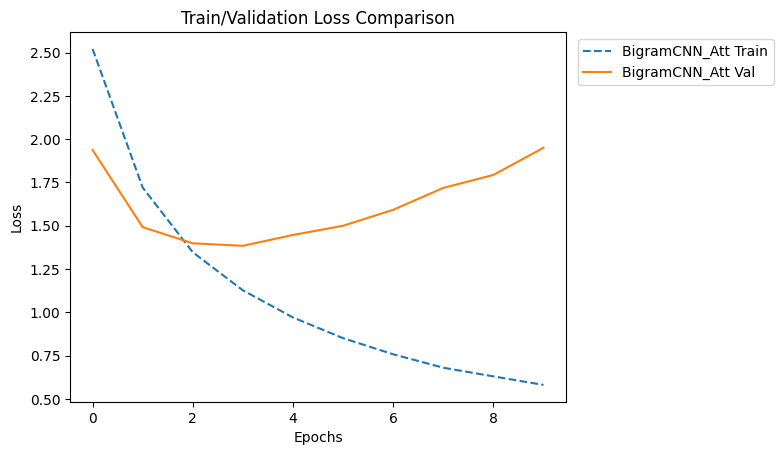

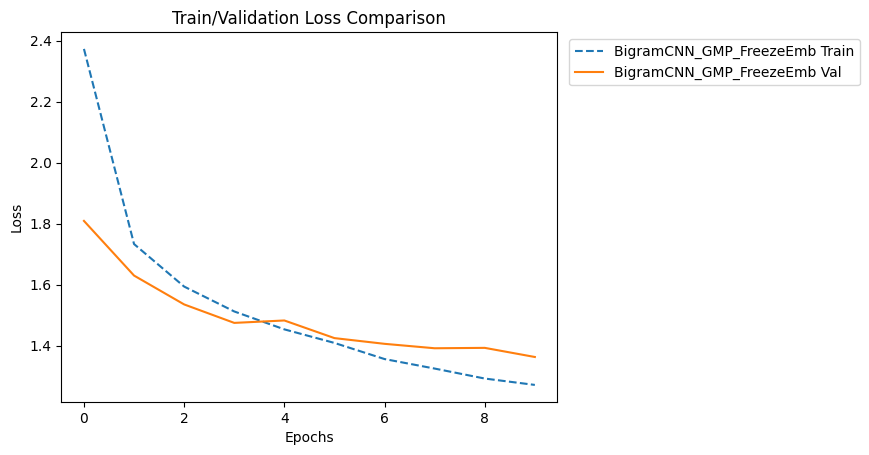

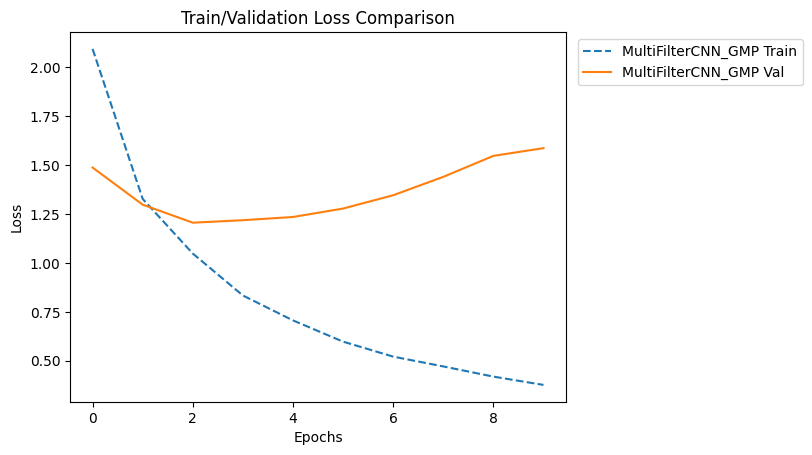

BigramCNN_GMP: Accuracy=0.4871, Precision=0.5034, Recall=0.4756, F1=0.4681
TrigramCNN_GMP: Accuracy=0.4476, Precision=0.4715, Recall=0.4376, F1=0.4311
BigramCNN_Att: Accuracy=0.5799, Precision=0.5916, Recall=0.5646, F1=0.5635
BigramCNN_GMP_FreezeEmb: Accuracy=0.5646, Precision=0.5736, Recall=0.5520, F1=0.5511
MultiFilterCNN_GMP: Accuracy=0.6355, Precision=0.6337, Recall=0.6240, F1=0.6242


In [11]:
# Instantiate models and train

num_classes = len(np.unique(y_train))
models = {
    'BigramCNN_GMP': CNNModel(vocab_size=len(vocab), embed_dim=300,
                              output_dim=num_classes,
                              num_filters=64, ngram_kernel_size=2,
                              num_layers=6,
                              use_pooling=True),
    'TrigramCNN_GMP': CNNModel(vocab_size=len(vocab), embed_dim=300,
                               output_dim=num_classes,
                               num_filters=64, ngram_kernel_size=3,
                               num_layers=6,
                               use_pooling=True),
    # 'FourgamCNN_GMP': CNNModel(vocab_size=len(vocab), embed_dim=300,
    #                            output_dim=num_classes,
    #                            num_filters=8, ngram_kernel_size=4, num_layers=1,
    #                            use_pooling=True),
    'BigramCNN_Att': CNNModel(vocab_size=len(vocab), embed_dim=300,
                              output_dim=num_classes,
                              num_filters=64, ngram_kernel_size=2,
                              num_layers=3,
                              use_attention=True, attention_dim=16),
    # 'BigramCNN_GMP_RandomInit': CNNModel(vocab_size=len(vocab), embed_dim=300,
    #                                      output_dim=num_classes,
    #                                      num_filters=64, ngram_kernel_size=2,
    #                                      num_layers=3,
    #                                      pretrained_embeddings=False,
    #                                      use_pooling=True),
    'BigramCNN_GMP_FreezeEmb': CNNModel(vocab_size=len(vocab), embed_dim=300,
                                        output_dim=num_classes,
                                        num_filters=64, ngram_kernel_size=2,
                                        num_layers=3,
                                        freeze_embeddings=True,
                                        use_pooling=True),
    'MultiFilterCNN_GMP': MultiFilterCNNModel(
        vocab_size=len(vocab), embed_dim=300, output_dim=num_classes,
        num_filters=64, num_layers=1, use_pooling=True
    )
}

results = {}
epochs = 10

for name, model in models.items():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {name}...")
    print(model)
    train_losses, val_losses, best_model_checkpoint_path = train_model(model.to(device), train_loader, val_loader,
                                           criterion, optimizer, epochs=epochs)

    # load best model checkpoint for validation set inference
    best_model = deepcopy(model)
    best_model.load_state_dict(torch.load(best_model_checkpoint_path, weights_only=True))
    best_model.to(device)

    results[name] = {'train_loss': train_losses, 'val_loss': val_losses}
    acc, prec, rec, f1 = evaluate_model(best_model, val_loader)
    results[name].update({'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})

# Plot losses
for name in models:
    plt.plot(results[name]['train_loss'], linestyle='--', label=f'{name} Train')
    plt.plot(results[name]['val_loss'], label=f'{name} Val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train/Validation Loss Comparison')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

# Print evaluation metrics
for name, metrics in results.items():
    print(f"{name}: Accuracy={metrics['accuracy']:.4f}, Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")